# Sentiment Classification of Microblogs

## Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import re
! pip install wordninja
! pip install fasttext
import wordninja
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import *
import warnings 
# import pandas_profiling
warnings.filterwarnings("ignore", category=DeprecationWarning)

def clean_dollar(s):                                    #### Remove words starting with $ (Company names)
    p = r"\$[\w]*"
    r = re.findall(p, s)
    
    for i in r:
        s = re.sub("\\"+i, '', s)
    return s    
def clean_hash(s):                                      #### Clean text in hash 
    p = r"#[\w]*['?[\w]*]*"                             #### eg:- #ownitdon'ttradeit --> phrases in hashed text carry crucial informationabou the sentiment
    r = re.findall(p, s)                                #### People generally tend to use hash to represent entities, reactions, sentiments, opinions.

    for i in r:                                         #### Hence it is crucial not to remove them and instead extract the joined text and split them 
        s = re.sub(i, ' '.join(wordninja.split(i)), s)  
    return s    


def clean_negation(s):                                  ##### Negatoin indicators carry important information about the intent
    p = r"[A-Za-z]*n't"                                 ##### It's crucial to keep them
    r = re.findall(p, s)
    d = {"shan't":"should not", "won't":"will not", "ain't":"am not", "can't":"can not"}
                                                        ##### Not is sometimes written in short form, we can just replace "n't" to " not" except for these 4 short forms
    for i in r:
        if i in d.keys():
            s = re.sub(i, d[i], s)
        else:
            s = re.sub(i, i[:-3]+" not", s)
    return s

def get_key(num, percent=False):
    num = float(num)
    key = "increase" if num >0 else "decrease" if num<0 else ""

    if abs(num) == 0:
        return ""

    return key if not percent else "percent "+key

def clean_numbers(s):                                   
    s = s.replace(" %", "%")
#     print(s)
    p = r"[\+-][0-9]+\.?[0-9]*%"
    r = re.findall(p, s)
#     print(r)
    for i in r:
#         print(i)
        s = s.replace(i, get_key(i.strip()[:-1], True))

    p = r"[\+-][0-9]+\.?[0-9]*"
    r = re.findall(p, s)
#     print(r)
    for i in r:
#         print(i)
        s = s.replace(i, get_key(i.strip()))
    
    return s

def clean_punc(s):
    p = "[^a-zA-Z]"
    r = re.findall(p, s)
    for i in list(set(r)):
        s = s.replace(i, " ")
    return s

     |████████████████████████████████| 542kB 2.8MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp36-none-any.whl size=541552 sha256=ab593cc43f5f0305837dc501605b7a7900530ee4154c8b3095daea5a56639b4b
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja
     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2385140 sha256=34035f5ce130378e9f2f8cb291d85a38db93f76ca2b0ecbd863370b649f91592
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Un

In [2]:
df = pd.read_json("Microblog_Trainingdata.json.txt")
# df.to_csv("data.csv", index=False, header=True)
# print(df.info())

# #### 0. Remove Unnecessary columns
# df.drop(["id", "source", "cashtag"], axis=1, inplace=True)

#### 1. Join Sentences
df["joined"]=df.spans.apply(lambda x: ' '.join([i.strip() for i in x]))

#### 2. Drop rows with empty Strings
# print(df.shape)
df = df.loc[df.joined != '', :].reset_index(drop=True).copy(deep=True)
# print(df.shape)
df.sort_values(by='joined', inplace=True)
# df.to_csv("data.csv", index=False, header=True)

#### 3. Remove rows with Duplicate strings
df = df.groupby("joined")["sentiment score"].mean().reset_index().copy(deep=True)

#### 4. Remove Company Tags;  Convert text to lower case
df["comp_removed"] = df["joined"].apply(clean_dollar)
df["comp_removed"] = df["comp_removed"].str.lower()
df
#### 5. Remove hash(#) & split the ccombined words in hashtag
df['hash_corrected'] = df["comp_removed"].apply(clean_hash)

#### 6. Negation Preservation before removing Stop Words
df['negate_preserved'] = df["hash_corrected"].apply(clean_negation)
#### 7. Remove Stop Words 
stops = [i for i in stopwords.words('english') if i not in ['not', 'high', 'low', 'up', 'down', 'above', 'below', 'under', 'over']]   #too, very can be used if an LSTM is used
df["stops_removed"] =  pd.Series([ " ".join([j for j in word_tokenize(i) if j not in stops]) for i in df["negate_preserved"]])

#### 8. Replace & encode numeric changes 
df['number_removed'] = df['stops_removed'].str.replace(" %", "%")
df['number_removed'] = df["number_removed"].apply(clean_numbers)

#### 9. Remove punctuation, special characters &  REMOVE EXTRA SPACES
df['punc_removed'] = df['number_removed'].apply(clean_punc)
df['punc_removed'] = df['punc_removed'].apply(lambda x: re.sub(' +', ' ', x))
df = df.groupby("punc_removed")["sentiment score"].mean().reset_index().copy(deep=True)

#### 10. Tokenize, Stem, Lemmatize
df['tokens'] = pd.Series([ [j for j in word_tokenize(i)] for i in df["punc_removed"]])
stemmer = porter.PorterStemmer()
lemmatizer = WordNetLemmatizer()
df['stemmed_tokens'] = df["tokens"].apply(lambda x: [stemmer.stem(i) for i in x]) 
df['lemmatized_tokens'] = df["tokens"].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

df['stemmed_blog'] = df["stemmed_tokens"].apply(lambda x: ' '.join(x))
df['lemmatized_blog'] = df["lemmatized_tokens"].apply(lambda x: ' '.join(x))

df = df.loc[(df["sentiment score"] != 0) & (df["punc_removed"]!='') & (df["punc_removed"]!=' '), :].reset_index(drop=True).copy(deep=True)


#### 10. Create Polarity flag for Clasification
df["sentiment_polarity"] = 0
df.loc[df["sentiment score"]>0, "sentiment_polarity"] = 1

df.shape

(1183, 8)

In [0]:
# p = pd.DataFrame(df.groupby("punc_removed").size().reset_index())
# p.columns = ["string", "num"]
# p.sort_values(by="num", ascending=False, inplace=True)
# a = p.loc[p.num>2, "string"].values
# a

In [0]:
# df.loc[df.punc_removed.isin(a), :].sort_values(by = "punc_removed")

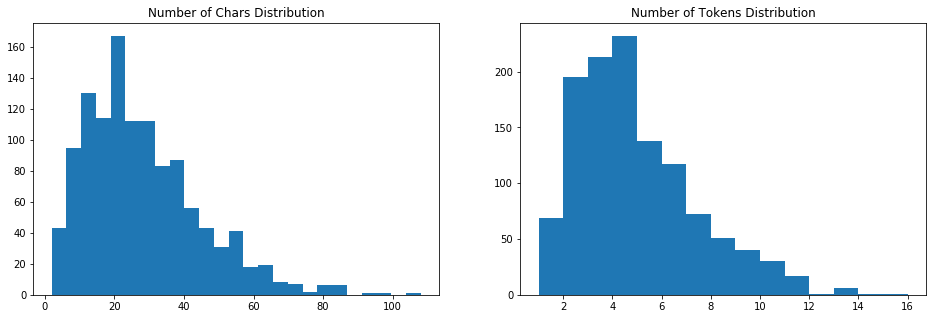

In [8]:
####### distribution of num of chars of the MicroBlogs
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(df.punc_removed.str.len(), bins=25, label="Num Chars")
ax1.set_title("Number of Chars Distribution")
ax2.hist(df.tokens.apply(len), bins=15, label="Num Tokens")
ax2.set_title("Number of Tokens Distribution")

plt.show()

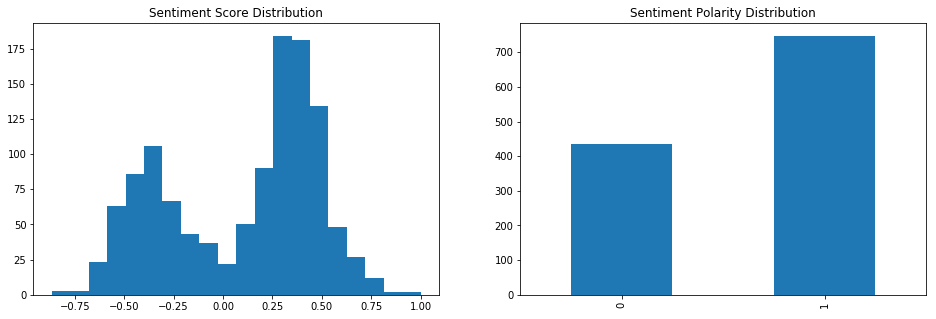

In [9]:
####### Distribution of Sentiment Score & Sentiment polarity

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(df["sentiment score"], bins=20, label="Sentiment Score")
ax1.set_title("Sentiment Score Distribution")
df["sentiment_polarity"].value_counts().sort_index(inplace=False).plot("bar", ax=ax2)
ax2.set_title("Sentiment Polarity Distribution")

plt.show()


__WordCloud__



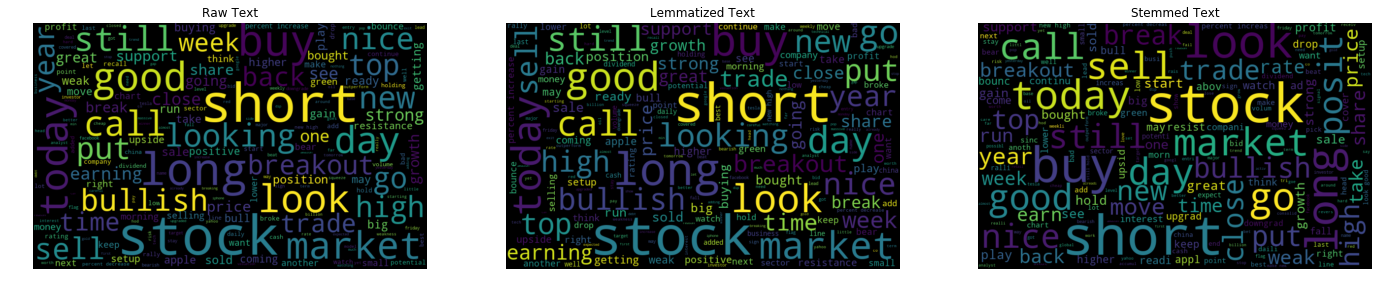

In [10]:
####### WordCloud
all_words = ' '.join([text for text in df.punc_removed])
from wordcloud import WordCloud

fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

all_words = ' '.join([text for text in df.punc_removed])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
ax1.set_title("Raw Text")

all_words = ' '.join([text for text in df.lemmatized_blog])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
ax2.imshow(wordcloud, interpolation="bilinear")
ax2.axis('off')
ax2.set_title("Lemmatized Text")

all_words = ' '.join([text for text in df.stemmed_blog])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
ax3.imshow(wordcloud, interpolation="bilinear")
ax3.axis('off')
ax3.set_title("Stemmed Text")


plt.show()


## Feature Extraction

### Document Level Features
One feature vector for each document ( Word level embeddings are aggregated by taking average at a document level 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from gensim.models.fasttext import FastText
d = df.drop(["sentiment score"], axis=1, inplace=False).copy(deep=True)



Using TensorFlow backend.


#### Bag of Words Features

In [12]:
max_features = 1000
bow_extractor = CountVectorizer(ngram_range = (1,5), max_df=0.90, min_df=4, max_features=max_features )
bow = bow_extractor.fit_transform(d['lemmatized_blog'])
bow.shape

(1183, 324)

In [13]:
bow_extractor.transform(["he is a boy"])

<1x324 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### TF IDF Features

In [14]:
tfidf_extractor = TfidfVectorizer(ngram_range = (1,5), max_df=0.90, min_df=4, max_features=max_features)
tfidf = tfidf_extractor.fit_transform(d['lemmatized_blog'])
tfidf.shape

(1183, 324)

In [0]:
max_features = bow.shape[1]
num_samples = d.shape[0]

#### Word2Vec (Self Trained)


In [0]:
def generate_aggregate_features(source, sentences_list, vocab_list, feature_size):
    # source            - Any data structure(model/ dict etc) that allows lookup with the word name and returns a numpy array of embeddings
    # sentences_list    - List of list of tokens (List of sentences, each sentence is a list of tokens)
    # vocab_list        - List of unique words in the training data ( only those words whose embedding vectors are available )
    #                     Even with self trained model, all words won't have embeddings because 
    #                     we restrict training on words with a minimum occurance number to avoid overfiitng
    # feature_size      - Size of each word embedding vector 

    features = np.zeros((len(sentences_list), feature_size))

    for i in range(len(sentences_list)):
        doc_agg_vec = np.zeros((1, feature_size))
        num_matched_words = 0
        for word in sentences_list[i]:
            if word in vocab_list:
                doc_agg_vec += source[word].reshape((1, feature_size))
                num_matched_words += 1
            # else:
                # print(word)
        if num_matched_words > 0 :
            features[i, :] = doc_agg_vec / float(num_matched_words)

    return pd.DataFrame(features)
        

In [0]:
feature_size = 300
w2v_selftrained_model = gensim.models.Word2Vec(
    d.lemmatized_tokens, size=feature_size, window=5,
    min_count=2, negative = 10, workers= 2, seed = 5)

w2v_selftrained_model.train(d.lemmatized_tokens, total_examples= num_samples, epochs=30)
w2v_selftrained_vocab = list(w2v_selftrained_model.wv.vocab.keys())

w2v_selftrained_features = generate_aggregate_features(source = w2v_selftrained_model,
                                                       sentences_list = d.lemmatized_tokens.to_list(), 
                                                       vocab_list = w2v_selftrained_vocab,
                                                       feature_size = feature_size)

#### Word2Vec (Pre Trained)

In [18]:
%%bash
### Check  for the Pre Trained Word embeddings file and download if not exists 
if [ ! -f "./glove.6B.300d.txt" ] 
then
    rm *zip*
    wget http://nlp.stanford.edu/data/glove.6B.zip
    unzip -q glove.6B.zip
fi

rm: cannot remove '*zip*': No such file or directory
--2019-10-20 13:04:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-10-20 13:04:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-10-20 13:04:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M)

In [0]:
t = Tokenizer()
t.fit_on_texts(d.lemmatized_blog.values.tolist())
vocab_size = len(t.word_index) + 1

w2v_pretrained_lookup = {}

f = open('glove.6B.300d.txt')
for i in f:                              # Extract the pre trained embeddings of  words present in our Vocabulary
    x = i.split()
    w = x[0]

    if w.lower() in t.word_index:
        w2v_pretrained_lookup[w] = asarray(x[1:], dtype='float32')



w2v_pretrained_features = generate_aggregate_features(source = w2v_pretrained_lookup,
                                                       sentences_list = d.lemmatized_tokens.to_list(), 
                                                       vocab_list = list(w2v_pretrained_lookup.keys()),
                                                       feature_size = feature_size)

### Word Level Features
One feature vector for each word (or One matrix for each document)

In [0]:
####################  Document Level
feature_size_pre = 300

t = Tokenizer()
t.fit_on_texts(d.lemmatized_blog.values.tolist())
vocab_size = len(t.word_index) + 1

encoded_docs = t.texts_to_sequences(d.lemmatized_tokens.values.tolist())
# print(encoded_docs)
max_length = 16

padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# print(padded_docs)

wordvec_arrays_pre_ = np.zeros((vocab_size, feature_size_pre))

for i in t.word_index.keys():
    try:
        wordvec_arrays_pre_[t.word_index[i],:] = np.array(w2v_pretrained_lookup[i]).reshape((1, feature_size_pre))
    except KeyError:
        wordvec_arrays_pre_[t.word_index[i],:] = np.zeros((1, feature_size_pre))


---

## Build Model

In [92]:
! mkdir -p  ./Models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pickle

def evaluate(model, X_tr, X_te, y_tr, y_te, cr = False):
    
    results = pd.DataFrame(index=["Accuracy Score", "F1 Score"], columns=["Train", "Test"])
    
    y_pr_tr = model.predict(X_tr) 
    y_pr_te = model.predict(X_te)
    results.iloc[0,0] = accuracy_score(y_tr, y_pr_tr)
    results.iloc[0,1] = accuracy_score(y_te, y_pr_te)
    results.iloc[1,0] = f1_score(y_tr, y_pr_tr)
    results.iloc[1,1] = f1_score(y_te, y_pr_te)
    
    print("######## Results\n", results)  #.applymap(lambda x:round(x,3))*100

    if  cr:
        print("######## Train classification_report:\n", classification_report(y_tr, y_pr_tr))
        print("######## Test classification_report:\n", classification_report(y_te, y_pr_te))
        
    tr = pd.DataFrame(confusion_matrix(y_tr, y_pr_tr))
    te = pd.DataFrame(confusion_matrix(y_te, y_pr_te))

    if len(tr.columns) == 1:
        tr[[i for i in [0,1] if i not in tr.columns][0]]= 0
        tr = tr.iloc[:, [0,1]]

    if len(te.columns) == 1:
        te[[i for i in [0,1] if i not in te.columns][0]]= 0
        te = te.iloc[:, [0,1]]
    
    print("######## Confusion Matrix ")
    fig, axs = plt.subplots(1,2, figsize=(12, 4))
    sns.heatmap(tr/tr.sum(axis=1), annot=tr,  center=0.5, vmax=1, vmin=0, ax=axs[0], fmt='d', square=True, cbar=False, cmap='Blues' )
    axs[0].set_title("Train")
    sns.heatmap(te/te.sum(axis=1), annot=te,  center=0.5, vmax=1, vmin=0, ax=axs[1], fmt='d', square=True, cbar=False, cmap='Blues')
    axs[1].set_title("Test")
    
    for ax in axs.flat:
        ax.set(xlabel='Predicted', ylabel='Actual')

    plt.show()
    return results.values.ravel().tolist()


from imblearn.over_sampling import SMOTE
sm = SMOTE(n_jobs=-1)

m = ['LR', 'SVM', 'RF', 'XGB', 'NN'] 
f = ['BoW', "TfIdf", "w2v - Self", "w2v - Pre", "d2v"]
ind = pd.MultiIndex.from_tuples([(i, j) for i in m for j in f] + [('CNN', 'w2v - Pre'), ('RNN', 'w2v - Pre')])
results_df = pd.DataFrame(index = ind, columns=['train_acc', 'test_acc', 'train_f1', 'test_f1'])
results_df.index.names = ['model_type', 'feature_type']
# results_df

train_acc test_acc train_f1 test_f1
model_type feature_type                                    
LR         BoW                NaN      NaN      NaN     NaN
           TfIdf              NaN      NaN      NaN     NaN
           w2v - Self         NaN      NaN      NaN     NaN
           w2v - Pre          NaN      NaN      NaN     NaN
           d2v                NaN      NaN      NaN     NaN
SVM        BoW                NaN      NaN      NaN     NaN
           TfIdf              NaN      NaN      NaN     NaN
           w2v - Self         NaN      NaN      NaN     NaN
           w2v - Pre          NaN      NaN      NaN     NaN
           d2v                NaN      NaN      NaN     NaN
RF         BoW                NaN      NaN      NaN     NaN
           TfIdf              NaN      NaN      NaN     NaN
           w2v - Self         NaN      NaN      NaN     NaN
           w2v - Pre          NaN      NaN      NaN     NaN
           d2v                NaN      NaN      NaN     NaN
XGB        BoW                NaN      NaN      NaN     NaN
           TfIdf              NaN      NaN      NaN     NaN
           w2v - Self         NaN      NaN      NaN     NaN
           w2v - Pre          NaN      NaN      NaN     NaN
           d2v                NaN      NaN      NaN     NaN
NN         BoW                NaN      NaN      NaN     NaN
           TfIdf              NaN      NaN      NaN     NaN
           w2v - Self         NaN      NaN      NaN     NaN
           w2v - Pre          NaN      NaN      NaN     NaN
           d2v                NaN      NaN      NaN     NaN
CNN        w2v - Pre          NaN      NaN      NaN     NaN
RNN        w2v - Pre          NaN      NaN      NaN     NaN

### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression(class_weight='balanced', n_jobs=-1 )
params = {'penalty':['l1', 'l2'],
"C":[0.01, 0.05, 0.1, 0.5,  1, 5, 10],
"tol":np.linspace(0.00001, 0.005, 10),
"max_iter":[10, 50, 100, 500, 1000]}

model = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=3, n_jobs=-1, refit=True, verbose=1)

#### Bag-of-Words Features

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    8.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=1e-05, verbose=0,
                   warm_start=False)
######## Results
                    Train      Test
Accuracy Score  0.850056  0.760135
F1 Score        0.879855  0.814621
######## Train classification_report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80       327
           1       0.89      0.87      0.88       560

    accuracy                           0.85       887
   macro avg       0.84      0.84      0.84       887
weighted avg       0.85      0.85      0.85       887

######## Test classification_report:
               precision    recall  f1-score   support

           0       0.69      0.63      0.66       109
           1       0.80      0.83    

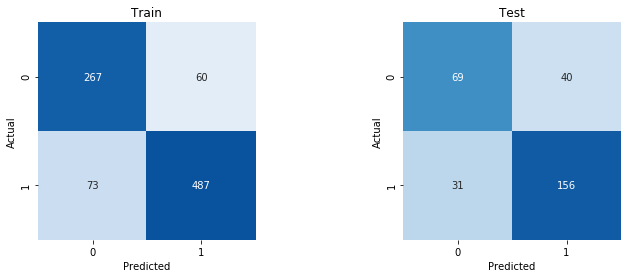

In [94]:
X = bow[:,:]
y = d["sentiment_polarity"]

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X, y,  
                                                          random_state=42, 
                                                          test_size=0.25, stratify=y)

# X_train_bow, y_train_bow = sm.fit_resample(X_train_bow, y_train_bow)

model.fit(X_train_bow, y_train_bow) # training the model
print(model.best_estimator_)
scores = evaluate(model, X_train_bow, X_test_bow, y_train_bow, y_test_bow, True)

results_df.loc[('LR', "BoW"), :] = scores
pickle.dump(model, open("./Models/LR_Bow.sav", 'wb'))

#### TF-IDF Features

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    7.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=1e-05, verbose=0,
                   warm_start=False)
######## Results
                    Train      Test
Accuracy Score  0.845547  0.760135
F1 Score         0.87713  0.816537
######## Confusion Matrix 


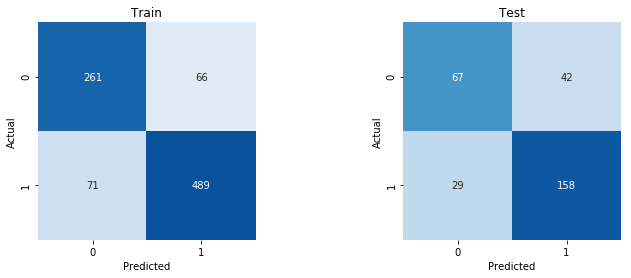

In [95]:
X = tfidf[:,:]
y = d["sentiment_polarity"]

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y,  
                                                          random_state=42, 
                                                          test_size=0.25, stratify=y)
# X_train_tfidf, y_train_tfidf = sm.fit_resample(X_train_tfidf, y_train_tfidf)

model.fit(X_train_tfidf, y_train_tfidf) # training the model
print(model.best_estimator_)
scores = evaluate(model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)

results_df.loc[("LR", "TfIdf"), :] = scores
pickle.dump(model, open("./Models/LR_TfIdf.sav", 'wb'))

#### Word2Vec SelfTrained Features

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:   26.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=1e-05, verbose=0,
                   warm_start=False)
######## Results
                    Train      Test
Accuracy Score  0.632469  0.628378
F1 Score        0.767143  0.762931
######## Confusion Matrix 


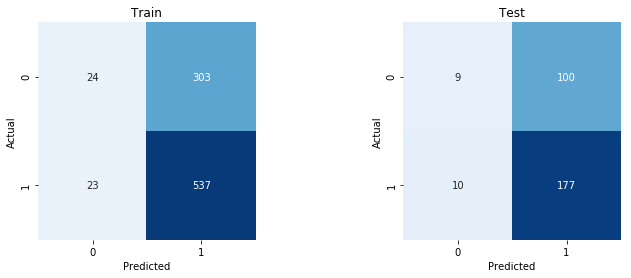

In [96]:
X = w2v_selftrained_features
y = d["sentiment_polarity"]

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X, y,random_state=42, test_size=0.25, stratify=y)

# X_train_w2v, y_train_w2v = sm.fit_resample(X_train_w2v, y_train_w2v)

model.fit(X_train_w2v, y_train_w2v) # training the model

print(model.best_estimator_)
scores = evaluate(model, X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v)
results_df.loc[( "LR" , "w2v - Self"), :] = scores

pickle.dump(model, open("./Models/LR_w2vself.sav", 'wb'))

#### Word2Vec Pretrained *Feature*s

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1402 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 2026 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=1e-05, verbose=0,
                   warm_start=False)
######## Results
                    Train      Test
Accuracy Score  0.838782  0.763514
F1 Score        0.869406  0.808743
######## Confusion Matrix 


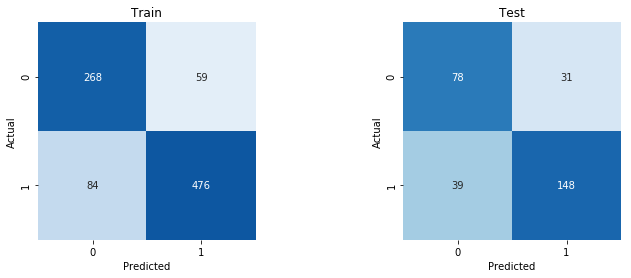

In [97]:
X = w2v_pretrained_features
y = d["sentiment_polarity"]
X_train_w2v_pre_agg, X_test_w2v_pre_agg, y_train_w2v_pre_agg, y_test_w2v_pre_agg = train_test_split(X, y,random_state=42, test_size=0.25, stratify=y)

# X_train_w2v_pre_agg, y_train_w2v_pre_agg = sm.fit_resample(X_train_w2v_pre_agg, y_train_w2v_pre_agg)

# lreg = LogisticRegression()
model.fit(X_train_w2v_pre_agg, y_train_w2v_pre_agg) # training the model
print(model.best_estimator_)
scores = evaluate(model, X_train_w2v_pre_agg, X_test_w2v_pre_agg, y_train_w2v_pre_agg, y_test_w2v_pre_agg)
results_df.loc[("LR", "w2v - Pre" ), :] = scores

pickle.dump(model, open("./Models/LR_w2vpre.sav", 'wb'))

### Support Vector Machine

In [0]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
svc = svm.SVC(class_weight='balanced')
p = {
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['auto', 'scale'],
    "C":[0.001, 0.005, 0.1, 0.5,  1, 2],
    "tol":np.linspace(0.0001, 0.001, 5),
    "shrinking":[True, False], 
    "degree":[1,2,3,4]
}
svc = GridSearchCV(estimator=svc, param_grid=p,scoring='accuracy', cv=3, n_jobs=-1, refit=True, verbose=1)

#### Bag-of-Words Features

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 3116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  1.5min finished


SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.0001, verbose=False)
######## Results
                    Train      Test
Accuracy Score  0.811725  0.746622
F1 Score        0.849142  0.806202
######## Confusion Matrix 


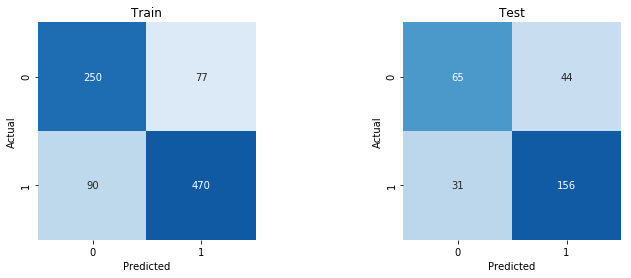

In [100]:
svc.fit(X_train_bow, y_train_bow)
print(svc.best_estimator_)
scores = evaluate(svc, X_train_bow, X_test_bow, y_train_bow, y_test_bow)

results_df.loc[('SVM', "BoW"), :] = scores

pickle.dump(model, open("./Models/SVM_BoW.sav", 'wb'))

#### TF-IDF Features

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 3116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  1.5min finished


SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.0001, verbose=False)
######## Results
                    Train     Test
Accuracy Score  0.821871     0.75
F1 Score         0.85918  0.80829
######## Confusion Matrix 


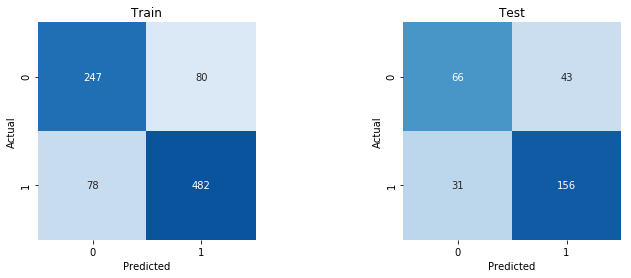

In [101]:
svc.fit(X_train_tfidf, y_train_tfidf)
print(svc.best_estimator_)
scores = evaluate(svc, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)

results_df.loc[('SVM', "TfIdf"), :] = scores

pickle.dump(model, open("./Models/SVM_TfIdf.sav", 'wb'))

#### Word2Vec Features

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  8.6min finished


######## Results
                    Train      Test
Accuracy Score  0.634724  0.628378
F1 Score        0.769886  0.763948
######## Confusion Matrix 


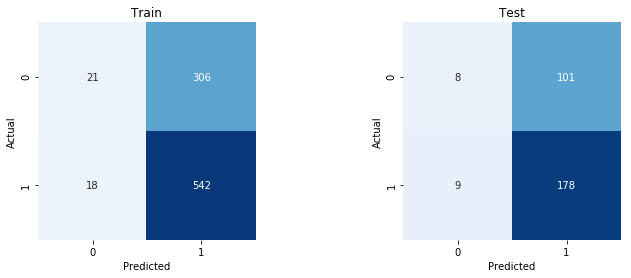

In [102]:
svc.fit(X_train_w2v, y_train_w2v)
scores = evaluate(svc, X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v)

results_df.loc[( "SVM" , "w2v - Self"), :] = scores

pickle.dump(model, open("./Models/SVM_w2vself.sav", 'wb'))

#### Word2Vec Pretrained Features

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   54.0s finished


SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.000325, verbose=False)
######## Results
                    Train      Test
Accuracy Score  0.838782  0.766892
F1 Score        0.867959  0.809917
######## Confusion Matrix 


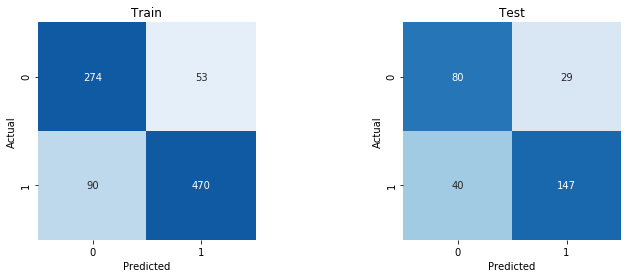

In [103]:
svc = svm.SVC(class_weight='balanced')
p = {
    "kernel":['linear'],
    "gamma":['auto', 'scale'],
    "C":[0.0001, 0.001, 0.1, 0.5,  1, 2, 3,  5],
    "tol": np.linspace(0.0001, 0.001, 5),
    "shrinking":[True, False]
}
svc = GridSearchCV(estimator=svc, param_grid=p,scoring='accuracy', cv=3, n_jobs=-1, refit=True, verbose=1)

svc.fit(X_train_w2v_pre_agg, y_train_w2v_pre_agg) # training the model
print(svc.best_estimator_)
results_df.loc[( "SVM" , "w2v - Pre"), :] = evaluate(svc, X_train_w2v_pre_agg, X_test_w2v_pre_agg, y_train_w2v_pre_agg, y_test_w2v_pre_agg)


pickle.dump(model, open("./Models/SVM_w2vpre.sav", 'wb'))

### RandomForest

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier( n_jobs=-1, class_weight='balanced')
p = {
    "n_estimators":list(range(5, 400, 10)),
    "max_depth":list(range(2,10)),
     "min_samples_split":list(range(3, 6)),
     "min_samples_leaf":list(range(1, 3))
}
rf = RandomizedSearchCV(estimator=rf, param_distributions=p, n_iter=300, scoring='roc_auc', cv=5, n_jobs=-1, refit=True, verbose=1)

#### Bag-of-Words Features

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  6.4min finished


######## Results
                    Train      Test
Accuracy Score  0.841037  0.760135
F1 Score        0.884141  0.829736
######## Confusion Matrix 


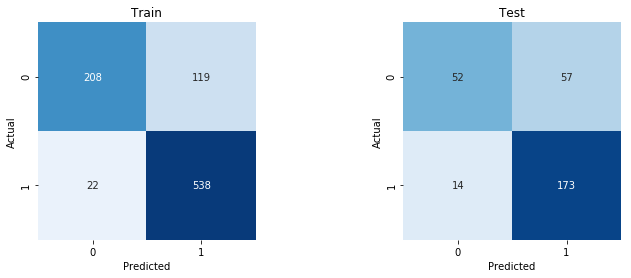

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=3, min_weight_fraction_leaf=0.0,
                       n_estimators=245, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [106]:
rf.fit(X_train_bow, y_train_bow)
scores = evaluate(rf, X_train_bow, X_test_bow, y_train_bow, y_test_bow)
print(rf.best_estimator_)

results_df.loc[('RF', "BoW"), :] = scores

pickle.dump(model, open("./Models/RF_BoW.sav", 'wb'))


#### TF-IDF Features

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  6.4min finished


######## Results
                    Train      Test
Accuracy Score  0.850056  0.743243
F1 Score        0.889259  0.815534
######## Confusion Matrix 


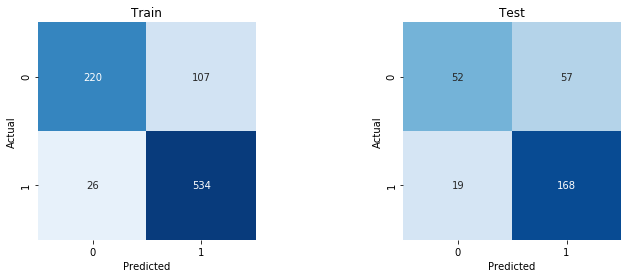

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=385, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [107]:
rf.fit(X_train_tfidf, y_train_tfidf)
scores = evaluate(rf, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)
print(rf.best_estimator_)
results_df.loc[('RF', "TfIdf"), :] = scores

pickle.dump(model, open("./Models/RF_TfIdf.sav", 'wb'))


#### Word2Vec Features

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 17.3min finished


######## Results
                    Train      Test
Accuracy Score  0.984216  0.655405
F1 Score        0.987342  0.764977
######## Confusion Matrix 


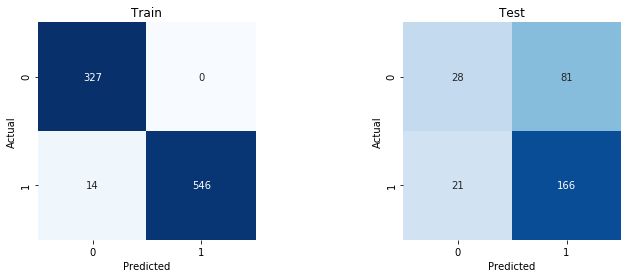

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=4, min_weight_fraction_leaf=0.0,
                       n_estimators=155, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [108]:
rf = RandomForestClassifier( n_jobs=-1, class_weight='balanced')
p = {
    "n_estimators":list(range(5, 400, 10)),
    "max_depth":list(range(2,10)),
     "min_samples_split":list(range(3, 6)),
     "min_samples_leaf":list(range(1, 3))
}
rf = RandomizedSearchCV(estimator=rf, param_distributions=p, n_iter=300, scoring='roc_auc', cv=5, n_jobs=-1, refit=True, verbose=1)


rf.fit(X_train_w2v, y_train_w2v)
scores = evaluate(rf, X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v)
print(rf.best_estimator_)
results_df.loc[('RF', "w2v - Self"), :] = scores

pickle.dump(model, open("./Models/RF_w2vself.sav", 'wb'))


#### Word2Vec Pretrained Features

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 17.9min finished


######## Results
                    Train      Test
Accuracy Score  0.979707  0.736486
F1 Score          0.9839  0.808824
######## Confusion Matrix 


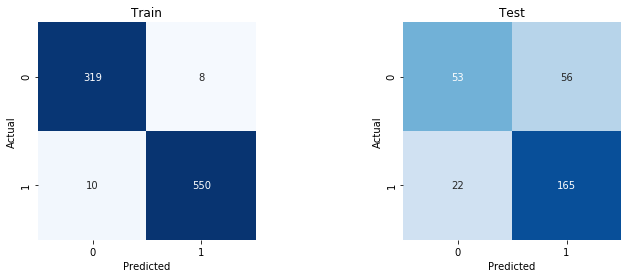

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=375, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [164]:
rf.fit(X_train_w2v_pre_agg, y_train_w2v_pre_agg) # training the model
scores = evaluate(rf, X_train_w2v_pre_agg, X_test_w2v_pre_agg, y_train_w2v_pre_agg, y_test_w2v_pre_agg)
print(rf.best_estimator_)
results_df.loc[('RF', "w2v - Pre"), :] = scores

pickle.dump(model, open("./Models/RF_w2vpre.sav", 'wb'))


### XGBoost

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier, XGBRFClassifier
xgb = XGBClassifier(max_depth=6, n_estimators=500, n_jobs=-1, objective='binary:logistic', scale_pos_weight=sum(y == 0)/sum(y == 1))

params = {
              'n_estimators': list(range(50, 800, 25)),
              'learning_rate': np.linspace(0.01, 0.07, 10),
              'subsample': np.linspace(0.3, 0.7, 10),
              'max_depth': [ i for i in range(2,10) ],
              'colsample_bytree': np.linspace(0.5, 0.75, 10),
              'min_child_weight': [i for i in range(1,5)],
              'eta' : [.3, .2, .1, .05, .01, 0.001, .005]
             }
xgb = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=100, scoring='f1', cv=3, verbose=1, refit=True, n_jobs=-1)


#### Bag-of-Words Features

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   57.0s finished


######## Results
                    Train      Test
Accuracy Score  0.715896  0.712838
F1 Score        0.806748  0.805492
######## Train classification_report:
               precision    recall  f1-score   support

           0       0.76      0.33      0.46       327
           1       0.71      0.94      0.81       560

    accuracy                           0.72       887
   macro avg       0.73      0.64      0.64       887
weighted avg       0.73      0.72      0.68       887

######## Test classification_report:
               precision    recall  f1-score   support

           0       0.76      0.32      0.45       109
           1       0.70      0.94      0.81       187

    accuracy                           0.71       296
   macro avg       0.73      0.63      0.63       296
weighted avg       0.72      0.71      0.68       296

######## Confusion Matrix 


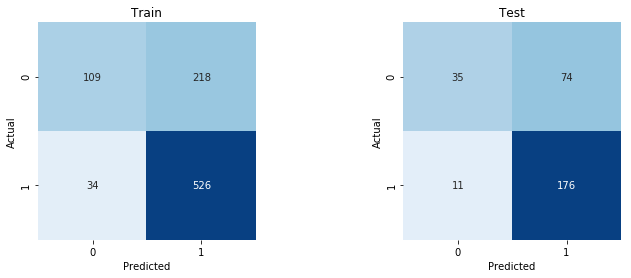

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6388888888888888,
              eta=0.005, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=2, min_child_weight=2, missing=None, n_estimators=275,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.5836680053547524, seed=None, silent=None,
              subsample=0.5222222222222221, verbosity=1)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [160]:
xgb.fit(X_train_bow, y_train_bow)

scores = evaluate(xgb, X_train_bow, X_test_bow, y_train_bow, y_test_bow, True)
print(xgb.best_estimator_)

results_df.loc[('XGB', "BoW"), :] = scores

pickle.dump(model, open("./Models/XGB_BoW.sav", 'wb'))

#### TF-IDF Features

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   56.9s finished


######## Results
                    Train      Test
Accuracy Score  0.737317  0.719595
F1 Score        0.818677  0.808314
######## Train classification_report:
               precision    recall  f1-score   support

           0       0.79      0.39      0.52       327
           1       0.73      0.94      0.82       560

    accuracy                           0.74       887
   macro avg       0.76      0.67      0.67       887
weighted avg       0.75      0.74      0.71       887

######## Test classification_report:
               precision    recall  f1-score   support

           0       0.76      0.35      0.48       109
           1       0.71      0.94      0.81       187

    accuracy                           0.72       296
   macro avg       0.74      0.64      0.64       296
weighted avg       0.73      0.72      0.69       296

######## Confusion Matrix 


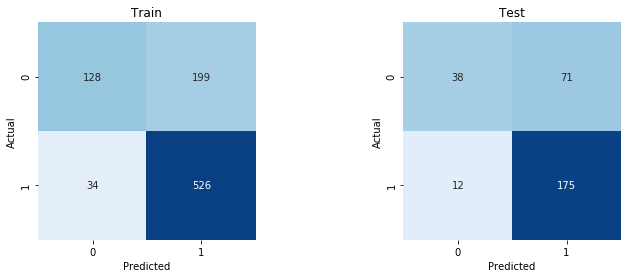

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7222222222222222, eta=0.05,
              gamma=0, learning_rate=0.023333333333333334, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=None, n_estimators=150,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.5836680053547524, seed=None, silent=None,
              subsample=0.6555555555555554, verbosity=1)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [161]:
xgb.fit(X_train_tfidf, y_train_tfidf)
scores = evaluate(xgb, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, True)
print(xgb.best_estimator_)

results_df.loc[('XGB', "TfIdf"), :] = scores

pickle.dump(model, open("./Models/XGB_TfIdf.sav", 'wb'))

#### Word2Vec Features

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.9min finished


######## Results
                    Train      Test
Accuracy Score  0.984216  0.668919
F1 Score        0.987342  0.752525
######## Train classification_report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       327
           1       1.00      0.97      0.99       560

    accuracy                           0.98       887
   macro avg       0.98      0.99      0.98       887
weighted avg       0.98      0.98      0.98       887

######## Test classification_report:
               precision    recall  f1-score   support

           0       0.56      0.45      0.50       109
           1       0.71      0.80      0.75       187

    accuracy                           0.67       296
   macro avg       0.64      0.62      0.63       296
weighted avg       0.66      0.67      0.66       296

######## Confusion Matrix 


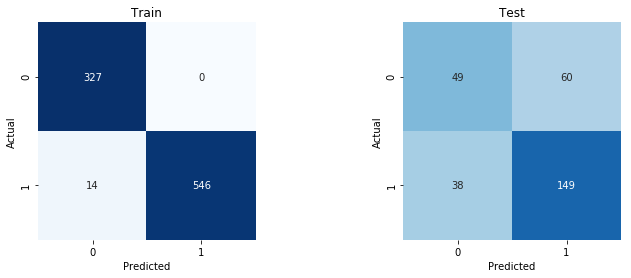

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6944444444444444, eta=0.01,
              gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=575, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5836680053547524,
              seed=None, silent=None, subsample=0.611111111111111, verbosity=1)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [162]:
xgb.fit(X_train_w2v, y_train_w2v)
scores = evaluate(xgb, X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v, True)
print(xgb.best_estimator_)

results_df.loc[('XGB', "w2v - Self"), :] = scores

pickle.dump(model, open("./Models/XGB_w2vself.sav", 'wb'))

#### Word2Vec Pretrained Features

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.1min finished


######## Results
                    Train      Test
Accuracy Score  0.998873  0.746622
F1 Score        0.999106   0.81203
######## Confusion Matrix 


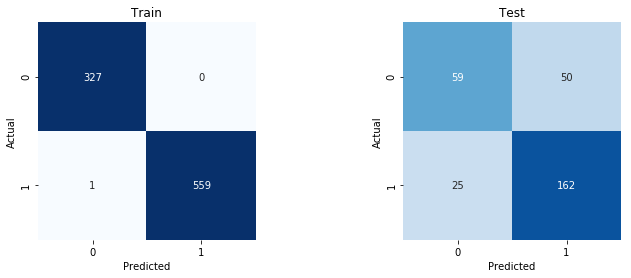

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6666666666666666, eta=0.3,
              gamma=0, learning_rate=0.03666666666666667, max_delta_step=0,
              max_depth=6, min_child_weight=3, missing=None, n_estimators=300,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.5836680053547524, seed=None, silent=None,
              subsample=0.611111111111111, verbosity=1)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [163]:
xgb.fit(X_train_w2v_pre_agg, y_train_w2v_pre_agg) # training the model
scores = evaluate(xgb, X_train_w2v_pre_agg, X_test_w2v_pre_agg, y_train_w2v_pre_agg, y_test_w2v_pre_agg)
print(xgb.best_estimator_)

results_df.loc[('XGB', "w2v - Pre"), :] = scores

pickle.dump(model, open("./Models/XGB_w2vpre.sav", 'wb'))

### Neural Networks

In [0]:
# first neural network with keras tutorial
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.utils import class_weight
from keras import regularizers

def model_nn(input_size, opt='adam'):
    model = Sequential()
    model.add(Dense(256, input_dim=input_size, activation='relu'))
    model.add(Dropout(0.30))
    model.add(Dense(64,  activation='relu'))
    model.add(Dropout(0.30))
    model.add(Dense(16,  activation='relu'))
    model.add(Dropout(0.30))
    model.add(Dense(2, activation='softmax'))
    o = SGD(lr=0.01, momentum=0.9) if opt=='sgd' else 'adam'
    model.compile(loss='binary_crossentropy', optimizer=o, metrics=['accuracy'])
    model.summary()
    return model


def fit_nn(model, trainX, testX, Y_tr, Y_te, epochs=50, batch_size=500, verbose=0):
    
    trainy = pd.get_dummies(Y_tr)
    testy = pd.get_dummies(Y_te)
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_tr),
                                                 Y_tr)
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.25, shuffle=True, class_weight=class_weights)
    # evaluate the model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    
    plt.figure(figsize=(14,4))
    # plot loss during training
    plt.subplot(121)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='test')
    plt.legend()
    plt.show()
    return

def evaluate_nn(model, X_tr, X_te, y_tr, y_te, cr=False):
    results = pd.DataFrame(index=["Accuracy Score", "F1 Score"], columns=["Train", "Test"])
    
    y_pr_tr = pd.Series(list(np.argmax(model.predict(X_tr), axis=1)))
    y_pr_te = pd.Series(list(np.argmax(model.predict(X_te), axis=1)))

    # print(X_tr.shape, X_te.shape, y_pr_tr.shape, y_pr_te.shape)

    results.iloc[0,0] = accuracy_score(y_tr, y_pr_tr)
    results.iloc[0,1] = accuracy_score(y_te, y_pr_te)
    results.iloc[1,0] = f1_score(y_tr, y_pr_tr)
    results.iloc[1,1] = f1_score(y_te, y_pr_te)
    print("######## Results\n", results.applymap(lambda x:round(x,3))*100)
    
    if  cr:
        print("######## Train classification_report:\n", classification_report(y_tr, y_pr_tr))
        print("######## Test classification_report:\n", classification_report(y_te, y_pr_te))
        
    tr = pd.DataFrame(confusion_matrix(y_tr, y_pr_tr))
    te = pd.DataFrame(confusion_matrix(y_te, y_pr_te))

    
    
    if len(tr.columns) == 1:
        tr[[i for i in [0,1] if i not in tr.columns][0]]= 0
        tr = tr.iloc[:, [0,1]]

    if len(te.columns) == 1:
        te[[i for i in [0,1] if i not in te.columns][0]]= 0
        te = te.iloc[:, [0,1]]

    print("############################ Confusion Matrix ############################")
    
    fig, axs = plt.subplots(1,2, figsize=(12, 4))
    sns.heatmap(tr/tr.sum(axis=1), annot=tr,  center=0.5, vmax=1, vmin=0, ax=axs[0], fmt='d', square=True, cbar=False, cmap='Blues' )
    axs[0].set_title("Train")
    sns.heatmap(te/te.sum(axis=1), annot=te,  center=0.5, vmax=1, vmin=0, ax=axs[1], fmt='d', square=True, cbar=False, cmap='Blues')
    axs[1].set_title("Test")
    
    for ax in axs.flat:
        ax.set(xlabel='Predicted', ylabel='Actual')

    
    return results.values.ravel().tolist()


#### Bag-of-Words Features

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 256)               83200     
_________________________________________________________________
dropout_73 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_74 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 16)                1040      
_________________________________________________________________
dropout_75 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 2)               

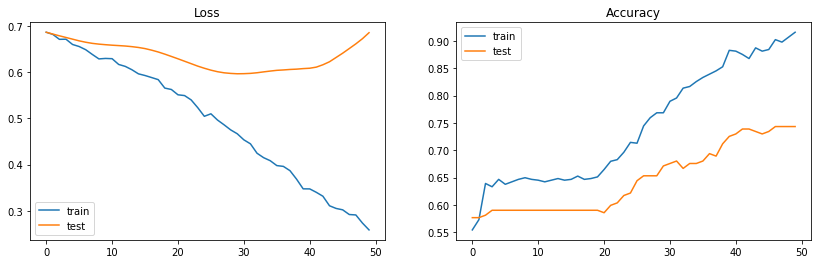

######## Results
                 Train  Test
Accuracy Score   87.7  73.6
F1 Score         90.6  81.6
############################ Confusion Matrix ############################


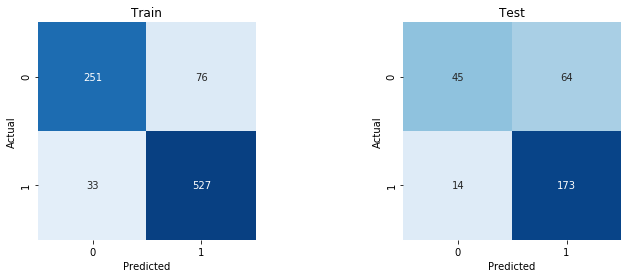

In [136]:
model = model_nn(max_features, 'adam')
fit_nn(model, X_train_bow, X_test_bow, y_train_bow, y_test_bow, 50, 1000)
scores = evaluate_nn(model, X_train_bow, X_test_bow, y_train_bow, y_test_bow)
results_df.loc[('NN', "BoW"), :] = scores

model.save('./Models/NN_BoW.h5') 

#### TF-IDF Features

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 256)               83200     
_________________________________________________________________
dropout_76 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_112 (Dense)            (None, 16)                1040      
_________________________________________________________________
dropout_78 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_113 (Dense)            (None, 2)               

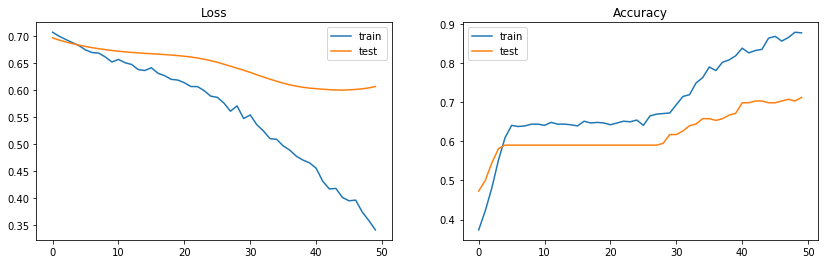

######## Results
                 Train  Test
Accuracy Score   86.4  75.3
F1 Score         89.8  82.7
############################ Confusion Matrix ############################


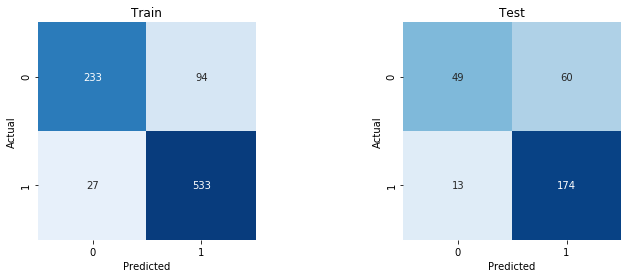

In [137]:
model = model_nn(max_features, 'adam')
fit_nn(model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, 50, 1000)
scores = evaluate_nn(model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)
results_df.loc[('NN', "TfIdf"), :] = scores

model.save('./Models/NN_TfIdf.h5') 

#### Word2Vec Features

In [0]:
def model_nn_2v(input_size, opt='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_size, activation='relu'))
    model.add(Dense(64,  activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,  activation='relu', kernel_regularizer=regularizers.l2(0.05)))
    model.add(Dense(16,  activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8,  activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    o = SGD(lr=0.01, momentum=0.9) if opt=='sgd' else 'adam'
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_91 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_63 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_93 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_64 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 8)               

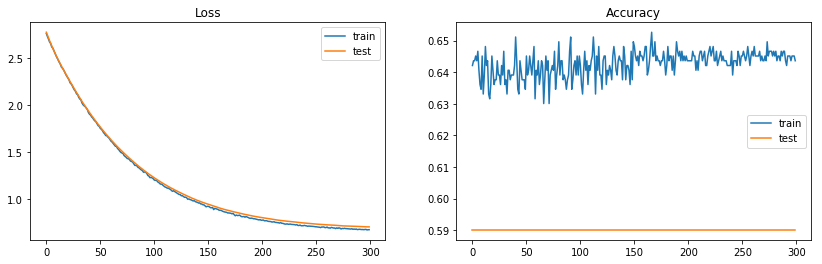

######## Results
                 Train  Test
Accuracy Score   63.1  63.2
F1 Score         77.4  77.4
############################ Confusion Matrix ############################


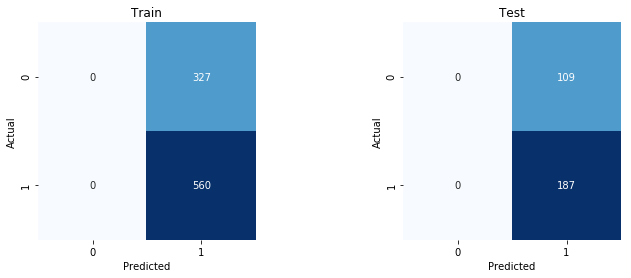

In [124]:
model = model_nn_2v(feature_size, 'adam')
fit_nn(model, X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v, 300, 1000)
scores = evaluate_nn(model, X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v)
results_df.loc[('NN', "w2v - Self"), :] = scores

model.save('./Models/NN_w2vself.h5') 


#### Word2Vec Pretrained Features

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_97 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_66 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_99 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_67 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 8)               

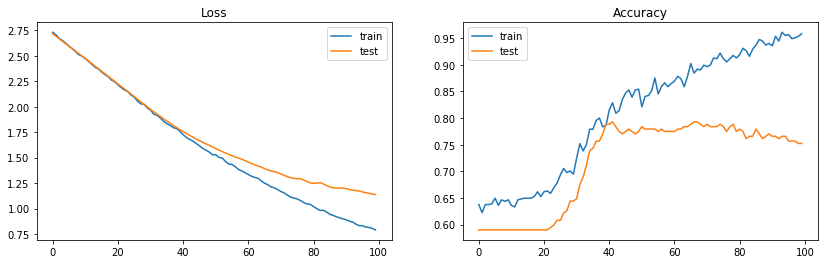

######## Results
                 Train  Test
Accuracy Score   91.9  78.0
F1 Score         93.6  82.9
############################ Confusion Matrix ############################


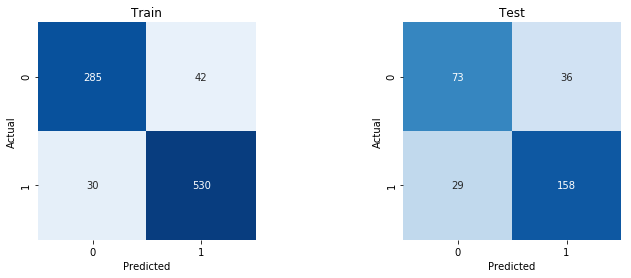

In [125]:
model = model_nn_2v(feature_size_pre, 'adam')
fit_nn(model, X_train_w2v_pre_agg, X_test_w2v_pre_agg, y_train_w2v_pre_agg, y_test_w2v_pre_agg, 100, 1000) # training the model
scores = evaluate_nn(model, X_train_w2v_pre_agg, X_test_w2v_pre_agg, y_train_w2v_pre_agg, y_test_w2v_pre_agg)
results_df.loc[('NN', "w2v - Pre"), :] = scores
model.save('./Models/NN_w2vpre.h5') 

#### Word2Vec Pretrained Features + CNN

In [0]:
from keras.layers import Flatten, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.recurrent import LSTM
from keras import regularizers

def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

def model_nn_2v_pre_cnn(vocab_size, feature_size, max_seq_len, weights, opt='adam', trainable=False):
    model = Sequential()
    model.add(Embedding(vocab_size, feature_size, input_length=max_seq_len, weights=[weights], trainable=trainable))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(16, activation='relu' ,kernel_regularizer=regularizers.l2(0.1)))  # , activity_regularizer=regularizers.l1(0.01)
    model.add(Dense(2, activation='softmax'))
    o = SGD(lr=0.01, momentum=0.9) if opt=='sgd' else 'adam'
    
    model.compile(loss='binary_crossentropy', optimizer=o, metrics=['accuracy'])
    
    model.summary()
    return model

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 300)           564000    
_________________________________________________________________
dropout_69 (Dropout)         (None, 16, 300)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 32)            48032     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 16)              

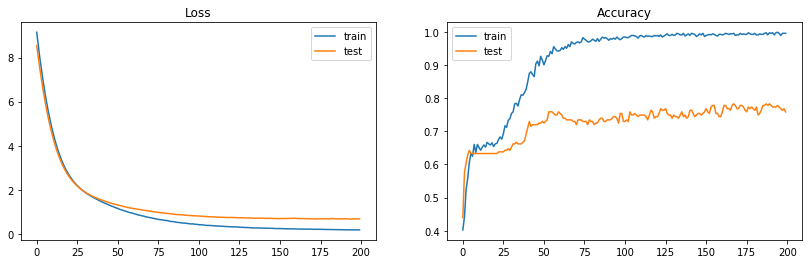

######## Results
                 Train  Test
Accuracy Score   93.7  76.3
F1 Score         95.1  82.9
######## Train classification_report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       305
           1       0.94      0.96      0.95       523

    accuracy                           0.94       828
   macro avg       0.94      0.93      0.93       828
weighted avg       0.94      0.94      0.94       828

######## Test classification_report:
               precision    recall  f1-score   support

           0       0.77      0.51      0.61       131
           1       0.76      0.91      0.83       224

    accuracy                           0.76       355
   macro avg       0.77      0.71      0.72       355
weighted avg       0.76      0.76      0.75       355

############################ Confusion Matrix ############################


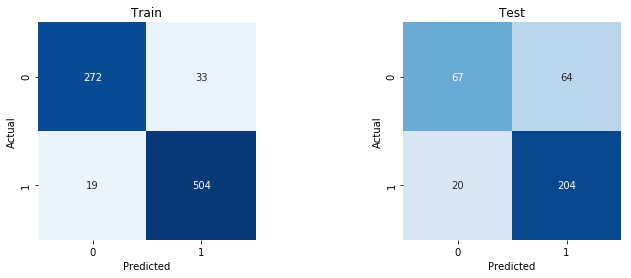

In [127]:

X_tr, X_te, y_tr, y_te = train_test_split(d.index, y, test_size=0.3, stratify = y)

X_train_w2v_pre_cnn =  padded_docs[X_tr.tolist(), :]
X_test_w2v_pre_cnn =  padded_docs[X_te.tolist(), :]
y_train_w2v_pre_cnn, y_test_w2v_pre_cnn = y_tr, y_te

model = model_nn_2v_pre_cnn(vocab_size, feature_size_pre, max_length, wordvec_arrays_pre_, trainable=True)
fit_nn(model, X_train_w2v_pre_cnn, X_test_w2v_pre_cnn, y_train_w2v_pre_cnn, y_test_w2v_pre_cnn, 200, 500, 1) # training the model
scores = evaluate_nn(model, X_train_w2v_pre_cnn, X_test_w2v_pre_cnn, y_train_w2v_pre_cnn, y_test_w2v_pre_cnn, True)

results_df.loc[('CNN', "w2v - Pre"), :] = scores
model.save('./Models/CNN_w2vpre.h5') 


#### Word2Vec Pretrained Features + LSTM

In [0]:
from keras.layers import Flatten, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.recurrent import LSTM
from keras import regularizers

def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

def model_nn_2v_pre_rnn(vocab_size, feature_size, max_seq_len, weights, opt='adam', trainable=False):
    model = Sequential()
    model.add(Embedding(vocab_size, feature_size, input_length=max_seq_len, weights=[weights], trainable=trainable))
    model.add(Dropout(0.3))
    # model.add(Conv1D(filters=32, kernel_size=5, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
    # model.add(MaxPooling1D(pool_size=4))
    # model.add(Flatten())
    model.add(LSTM(10))
    model.add(Dropout(0.3))
    
    model.add(Dense(8, activation='relu' ,kernel_regularizer=regularizers.l2(0.1)))  # , activity_regularizer=regularizers.l1(0.01)
    model.add(Dense(2, activation='softmax'))
    o = SGD(lr=0.01, momentum=0.9) if opt=='sgd' else 'adam'
    
    model.compile(loss='binary_crossentropy', optimizer=o, metrics=['accuracy'])
    
    model.summary()
    return model

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 300)           564000    
_________________________________________________________________
dropout_71 (Dropout)         (None, 16, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                12440     
_________________________________________________________________
dropout_72 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 8)                 88        
_________________________________________________________________
dense_105 (Dense)            (None, 2)                 18        
Total params: 576,546
Trainable params: 576,546
Non-trainable params: 0
_______________________________________________

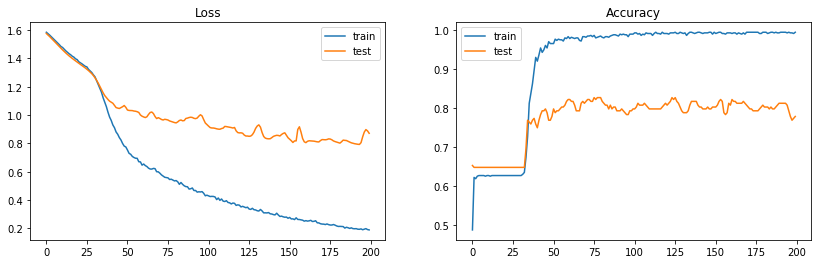

######## Results
                 Train  Test
Accuracy Score   94.0  74.4
F1 Score         95.1  79.1
######## Train classification_report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       305
           1       0.97      0.93      0.95       523

    accuracy                           0.94       828
   macro avg       0.93      0.94      0.94       828
weighted avg       0.94      0.94      0.94       828

######## Test classification_report:
               precision    recall  f1-score   support

           0       0.64      0.70      0.67       131
           1       0.82      0.77      0.79       224

    accuracy                           0.74       355
   macro avg       0.73      0.74      0.73       355
weighted avg       0.75      0.74      0.75       355

############################ Confusion Matrix ############################


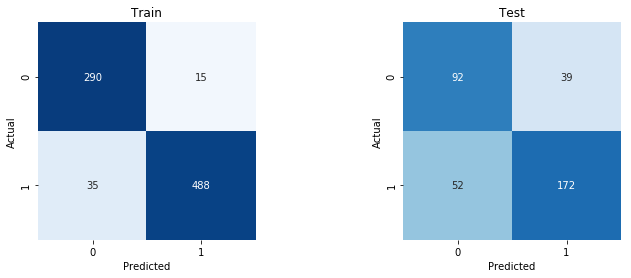

In [131]:

X_tr, X_te, y_tr, y_te = train_test_split(d.index, y, test_size=0.3, stratify = y)

X_train_w2v_pre_rnn =  padded_docs[X_tr.tolist(), :]
X_test_w2v_pre_rnn =  padded_docs[X_te.tolist(), :]
y_train_w2v_pre_rnn, y_test_w2v_pre_rnn = y_tr, y_te

model = model_nn_2v_pre_rnn(vocab_size, feature_size_pre, max_length, wordvec_arrays_pre_, trainable=True)
fit_nn(model, X_train_w2v_pre_rnn, X_test_w2v_pre_rnn, y_train_w2v_pre_rnn, y_test_w2v_pre_rnn, 200, 500, 1) # training the model
scores = evaluate_nn(model, X_train_w2v_pre_rnn, X_test_w2v_pre_rnn, y_train_w2v_pre_rnn, y_test_w2v_pre_rnn, True)

results_df.loc[('RNN', "w2v - Pre"), :] = scores

model.save('./Models/RNN_w2vpre.h5')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


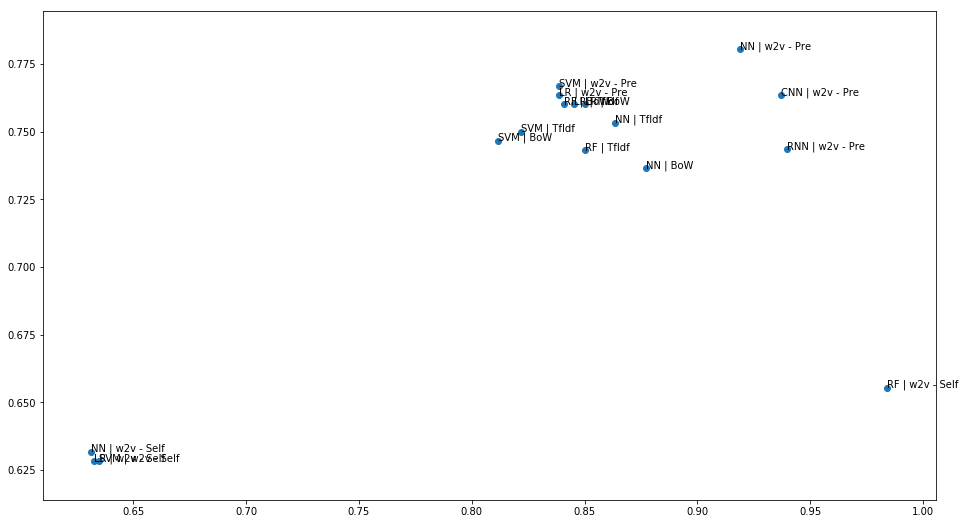

In [147]:
import pandas as pd
# results_df = pd.read_csv("results_df.csv")
results_df.reset_index(inplace=True)
results_df["id_"] = results_df.model_type + " | " + results_df.feature_type
# results_df.set_index(["model_type", "feeature_type"])
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,9))
plt.title('')
plt.scatter(results_df.train_acc, results_df.test_acc)
for i, lab in enumerate(results_df.id_):
    plt.annotate(lab, (results_df.train_acc[i], results_df.test_acc[i]))
# plt.plot(history.history['val_loss'], label='test')

plt.show()